In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras import backend as K
import concurrent.futures

tf.random.set_seed(10)

In [ ]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128
debug=1

In [ ]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
# dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
# dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# print(f"Shape of training images: {all_digits.shape}")
# print(f"Shape of training labels: {all_labels.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    print(f"Clients_name:{client_names[:5]}")
    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID

    #shard data and place at each client
    size = len(data)//num_clients
    print(f"Data points for each client:{size}")

    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

In [ ]:
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
def scale_model_weights_single_local(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [ ]:
def sum_scaled_weights_locals(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad

In [ ]:
def sum_scaled_weights_locals(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        #layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        layer_mean = tf.math.reduce_mean(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad

In [ ]:
# def sum_scaled_weights_locals(scaled_weight_list, counter_dict):
#     '''Return the sum of the listed scaled weights with modified scaling based on the counter dictionary.'''
# #     print(counter_dict)
#     avg_grad = []
#     for grad_list_tuple in zip(*scaled_weight_list):
#         updated_grad = []
#         for i, grad in enumerate(grad_list_tuple):
#             client_number = "client_"+str(i)
#             if counter_dict[client_number] <= 3:
#                 updated_grad.append(grad)
#         if updated_grad:  # Calculate layer_mean only if there are gradients to average
#             layer_mean = tf.math.reduce_mean(updated_grad, axis=0)
#             avg_grad.append(layer_mean)
# #     print(avg_grad)
#     return avg_grad

In [ ]:
def label_flip_targeted(one_hot_encoding):
  index_of_one = one_hot_encoding.index(1)
  next_index = (index_of_one + 1) % len(one_hot_encoding)
  new_encoding = [0] * len(one_hot_encoding)
  new_encoding[next_index] = 1
  if index_of_one == 9:
      return np.array(new_encoding).astype(np.float32)
  else:
      return new_encoding

In [ ]:
import numpy as np
import random

def label_flip_non_targeted(one_hot_encoding, flip_threshold):
    """
    Flips the label in the one-hot encoding if the index of one is less than the flip_threshold.
    """
    index_of_one = np.argmax(one_hot_encoding)
    num_labels = len(one_hot_encoding)

    # Check if the index of one is less than the flip_threshold
    if index_of_one < flip_threshold:
        # Generate a random label different from the actual one
        new_label = index_of_one
        while new_label == index_of_one:
            new_label = random.randint(0, num_labels - 1)

        new_encoding = np.zeros_like(one_hot_encoding)
        new_encoding[new_label] = 1
        return new_encoding.astype(np.float32)
    else:
        # Return the label as it is
        return one_hot_encoding


In [ ]:
one_hots = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
for vect in one_hots:
    flipped = label_flip_non_targeted(vect, 3)
    print(f"Original:{vect}\nFlipped: {flipped}")  # This will output the one-hot encoded list after label flipping


Original:[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Flipped: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original:[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Flipped: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Original:[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Flipped: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
clients = create_clients(all_digits, all_labels, num_clients=4, initial='client')

Clients_name:['client_1', 'client_2', 'client_3', 'client_4']
Data points for each client:17500


In [ ]:
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [ ]:
class ConditionalGANGlobal(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [ ]:
class ConditionalGANLocal(keras.Model):
    def __init__(self, discriminator, generator, latent_dim,global_gen_weights,global_disc_weights):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.generator.set_weights(global_gen_weights)
        self.discriminator.set_weights(global_disc_weights)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data
        one_hot_labels = tf.cast(one_hot_labels, tf.float32)
        real_images = tf.cast(real_images, tf.float32)

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.

        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )
        image_one_hot_labels = tf.cast(image_one_hot_labels, tf.float32)
        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim),dtype= tf.float32)
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)
        generated_images = tf.cast(generated_images, tf.float32)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)

        fake_image_and_labels = tf.cast(fake_image_and_labels, tf.float32)
        real_image_and_labels = tf.cast(real_image_and_labels, tf.float32)

        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [ ]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

global_cond_gan = ConditionalGANGlobal(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def detect_malicious_clients(gen_losses, disc_losses):
    """
    Detects malicious clients based on the absolute difference of losses.
    """
    # Calculate a score to prioritize higher generator losses and lower discriminator losses
    scores = np.array(gen_losses)/np.array(disc_losses)

    # Find the indices of clients with higher generator losses and lower discriminator losses
    malicious_clients = np.where(scores < np.mean(scores))[0]

    print(malicious_clients)
    if len(malicious_clients) == 3:
        malicious_clients = list(set([0, 1, 2, 3]) - set(malicious_clients))

    return malicious_clients

In [ ]:
# Initialize the dictionary with client names
client_names = [f'client_{i}' for i in range(len(clients_batched.keys()))]
counter = {client_name: 0 for client_name in client_names}

# Adding the key for global epoch/round
counter['global_epoch'] = 0  # Assuming the global round starts from 0


global_epochs = 10

attacker_nodes = [1]
for comm_round in range(global_epochs):
    global_gen_weights = global_cond_gan.generator.get_weights()
    global_disc_weights = global_cond_gan.discriminator.get_weights()

    scaled_local_gen = []
    scaled_local_disc = []
    local_gen_losses = []
    local_disc_losses = []

    print(f"\n<================  Common Round : {comm_round+1} ================>\n")
    for i, client in enumerate(clients_batched.keys()):
        smlp_local = ConditionalGANLocal(discriminator=discriminator, generator=generator, latent_dim=latent_dim,
                                         global_gen_weights=global_gen_weights, global_disc_weights=global_disc_weights)
        smlp_local.compile(
            d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
        )

        data_set = clients_batched[client]

        if i in attacker_nodes:
            Xt = []
            yt = []
            print("<================ Label Flipping Attack =================>")
            if i % 2 == 0:
                for images, labels in data_set:
                    flipped_labels = [label_flip_targeted(vect.numpy().tolist()) for vect in labels]
                    Xt.append(images)
                    yt.append(flipped_labels)
            else:
                for images, labels in data_set:
                    flipped_labels = [label_flip_targeted(vect.numpy().tolist()) for vect in labels]
                    Xt.append(images)
                    yt.append(flipped_labels)

            data_set = tf.data.Dataset.from_tensor_slices((Xt[:-1], yt[:-1]))

        print(f"<==============  Training at client {i+1} ==============>")
        if comm_round % 2 == 0:
            history = smlp_local.fit(data_set, epochs=4, verbose=1)
        else:
            history = smlp_local.fit(data_set, epochs=4, verbose=0)

        print(history.history)
        # Store losses
        for key in history.history:
            if 'g_loss' in key:
                local_gen_losses.append(history.history[key][-1])  # Take the last loss value
            elif 'd_loss' in key:
                local_disc_losses.append(history.history[key][-1])  # Take the last loss value

        scaled_local_gen.append(smlp_local.generator)
        scaled_local_disc.append(smlp_local.discriminator)

    # Print the local losses
    print("Local generator losses:", local_gen_losses)
    print("Local discriminator losses:", local_disc_losses)
    if comm_round > 0:

        malicious_clients = detect_malicious_clients(local_gen_losses, local_disc_losses)

        print("\n Highly malicious clients(Detected):", malicious_clients)

        # Update counter for malicious clients
        for val in malicious_clients:
            for key, value in counter.items():
                client_index = key.split('_')[-1]  # Extract the numeric part of the key
                if client_index == str(val):
                    counter[key] += 1
        counter['global_epoch'] = counter['global_epoch'] + 1

    print('Actual Attacker Node/Nodes:\t', attacker_nodes)
    print(counter)
    scaled_local_gen_weight_list = [scaled_local_gen[i].get_weights() for i in range(len(scaled_local_gen))]
    scaled_local_disc_weight_list = [scaled_local_disc[i].get_weights() for i in range(len(scaled_local_disc))]

    K.clear_session()

#     # Sum scaled weights
#     average_weights_gen = sum_scaled_weights_locals(scaled_local_gen_weight_list, counter)
#     average_weights_disc = sum_scaled_weights_locals(scaled_local_disc_weight_list, counter)
    # Sum scaled weights

    average_weights_gen = sum_scaled_weights_locals(scaled_local_gen_weight_list)
    average_weights_disc = sum_scaled_weights_locals(scaled_local_disc_weight_list)


    # Update global weights
    global_cond_gan.generator.set_weights(average_weights_gen)
    global_cond_gan.discriminator.set_weights(average_weights_disc)



<================  Common Round : 1 ================>

<==============  Training at client 1 ==============>
Epoch 1/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - d_loss: 0.5530 - g_loss: 0.9099
Epoch 2/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - d_loss: 0.3473 - g_loss: 1.3972
Epoch 3/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - d_loss: 0.4314 - g_loss: 1.2153
Epoch 4/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.5488 - g_loss: 0.9597
{'d_loss': [0.4462396800518036, 0.35583093762397766, 0.4890096187591553, 0.5407159328460693], 'g_loss': [1.136273980140686, 1.3970658779144287, 1.1124029159545898, 0.9666315913200378]}
<================ Label Flipping Attack =================>
<==============  Training at client 2 ==============>
Epoch 1/4
273/273 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - d_loss: 0.5505 - g_loss: 0.9169
Epoch 2/4
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - d_loss: 0.3554 - g_loss: 1.4053
Epoch 3/4
273/273 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - d_loss: 0.3661 - g_l

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Ensure TensorFlow 2.x behavior even if running TensorFlow 1.x code.
try:
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    tf.random.set_seed(42)
except Exception:
    pass

# Create a directory to store raw data if it doesn't exist.
raw_data_dir = "non_targetted_attack_C0_C1"
os.makedirs(raw_data_dir, exist_ok=True)

# Function to create a directory if it doesn't exist.
def create_class_dir(class_label):
    class_dir = os.path.join(raw_data_dir, f"class_{class_label}")
    os.makedirs(class_dir, exist_ok=True)
    return class_dir

# We first extract the trained generator from our Conditional GAN.
trained_gen = global_cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 50

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))

def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake

# Generate and save images for each class.
for i in range(10):
    start_class = i
    end_class = i
    fake_images = interpolate_class(start_class, end_class)

    # Scale and convert images to uint8.
    fake_images *= 255.0
    converted_images = fake_images.astype(np.uint8)
    converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)

    # Create a directory for the current class.
    class_dir = create_class_dir(i)

    # Save images in the class directory.
    for idx, img in enumerate(converted_images):
        plt.imshow(img)
        plt.savefig(os.path.join(class_dir, f"image_{idx}.png"))
        plt.close()

    print(f"{'-'*20} ✔✔✔ ✔✔✔ ({i}) ✔✔✔ ✔✔✔ {'-'*20}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 975ms/step
-------------------- ✔✔✔ ✔✔✔ (0) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-------------------- ✔✔✔ ✔✔✔ (1) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-------------------- ✔✔✔ ✔✔✔ (2) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-------------------- ✔✔✔ ✔✔✔ (3) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-------------------- ✔✔✔ ✔✔✔ (4) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
-------------------- ✔✔✔ ✔✔✔ (5) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-------------------- ✔✔✔ ✔✔✔ (6) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-------------------- ✔✔✔ ✔✔✔ (7) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-------------------- ✔✔✔ ✔✔✔ (8) ✔✔✔ ✔✔✔ --------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
-------------------- ✔✔✔ ✔✔✔ (9) ✔✔✔ ✔✔✔ --------------------

In [ ]:
!zip -r non_targetted_attack_C0_C1.zip non_targetted_attack_C0_C1

  adding: non_targetted_attack_C0_C1/ (stored 0%)
  adding: non_targetted_attack_C0_C1/class_7/ (stored 0%)
  adding: non_targetted_attack_C0_C1/class_7/image_23.png (deflated 12%)
  adding: non_targetted_attack_C0_C1/class_7/image_39.png (deflated 16%)
  adding: non_targetted_attack_C0_C1/class_7/image_42.png (deflated 15%)
  adding: non_targetted_attack_C0_C1/class_7/image_44.png (deflated 16%)
  adding: non_targetted_attack_C0_C1/class_7/image_2.png (deflated 16%)
  adding: non_targetted_attack_C0_C1/class_7/image_20.png (deflated 13%)
  adding: non_targetted_attack_C0_C1/class_7/image_33.png (deflated 15%)
  adding: non_targetted_attack_C0_C1/class_7/image_1.png (deflated 14%)
  adding: non_targetted_attack_C0_C1/class_7/image_14.png (deflated 13%)
  adding: non_targetted_attack_C0_C1/class_7/image_36.png (deflated 14%)
  adding: non_targetted_attack_C0_C1/class_7/image_30.png (deflated 15%)
  adding: non_targetted_attack_C0_C1/class_7/image_15.png (deflated 15%)
  adding: non_targ

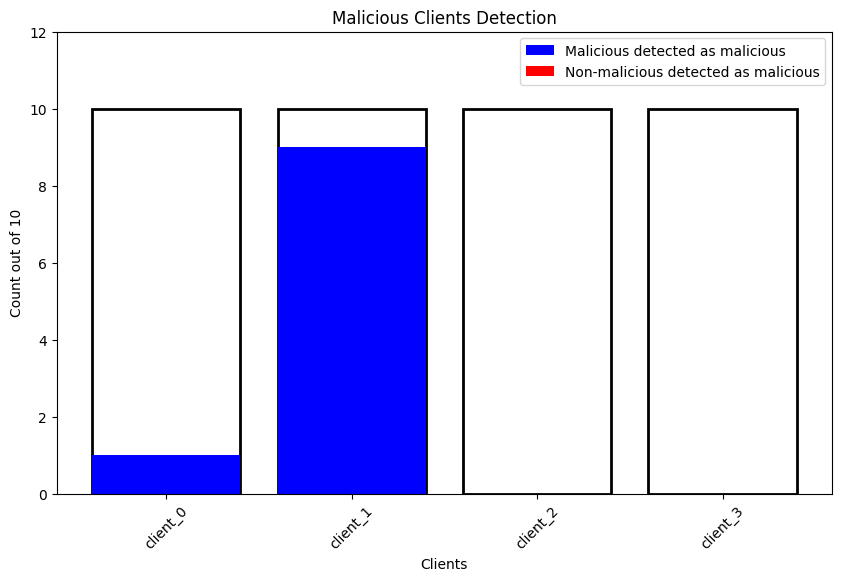

In [ ]:
import matplotlib.pyplot as plt

# Sample data
data = counter
attacker_nodes = [0, 1]  # Assuming client indices 0 and 1 are highly malicious

# Extract client names and counts
clients = list(data.keys())[:-1]  # Exclude 'global_epoch'
counts = list(data.values())[:-1]

# Plotting
plt.figure(figsize=(10, 6))

# Plot each bar
for i, client in enumerate(clients):
    color = 'blue' if i in attacker_nodes else 'red'  # Color based on maliciousness
    plt.bar(client, 10, color='white', edgecolor='black', linewidth=2, label='Border')  # Plot the border bars
    plt.bar(client, counts[i], color=color)  # Plot the filled bars

# Create custom legend entries
malicious_patch = plt.bar(0, 0, color='blue', label='Malicious detected as malicious')
non_malicious_patch = plt.bar(0, 0, color='red', label='Non-malicious detected as malicious')

plt.xlabel('Clients')
plt.ylabel('Count out of 10')
plt.title('Malicious Clients Detection')
plt.xticks(rotation=45)
plt.ylim(0, 12)  # Set y-axis limit from -1 to 11 to leave some margin at the top

# Display only the custom legend entries
plt.legend(handles=[malicious_patch, non_malicious_patch])
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


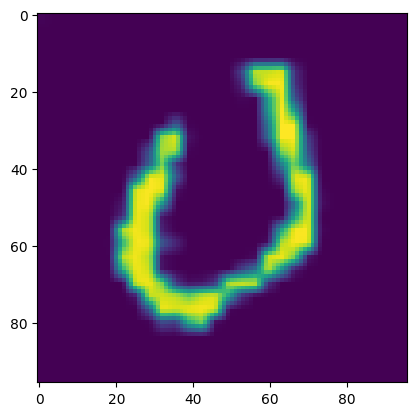

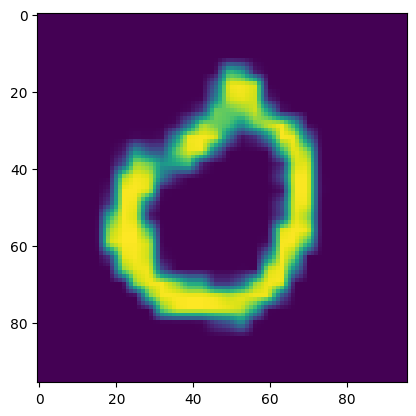

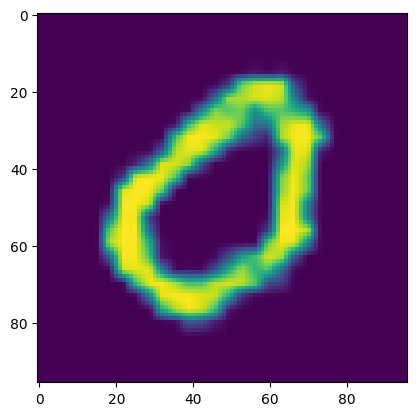

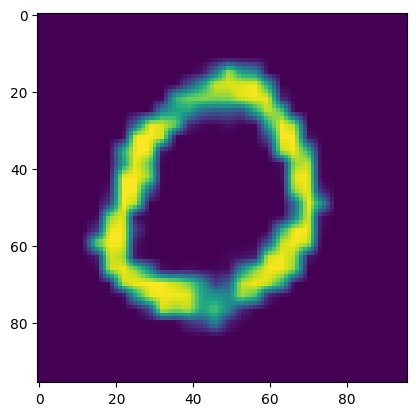

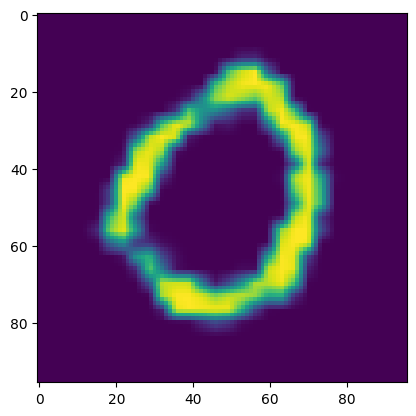

-------------------- ✔✔✔ ✔✔✔ (0) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


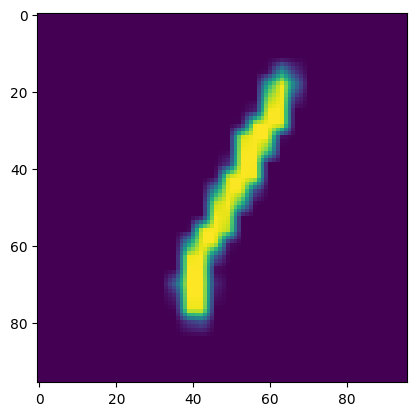

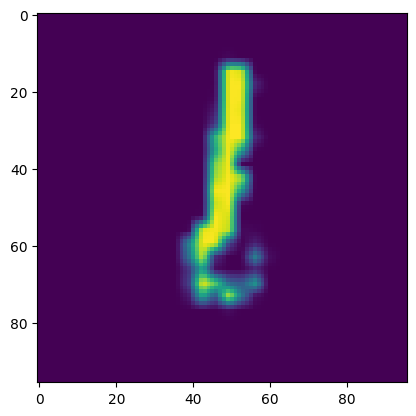

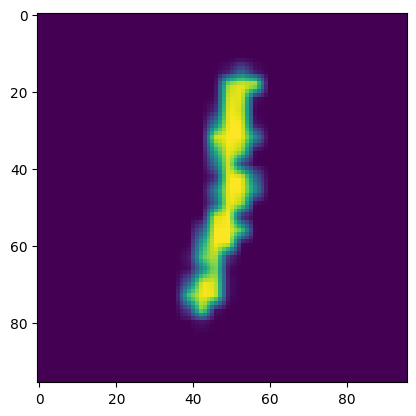

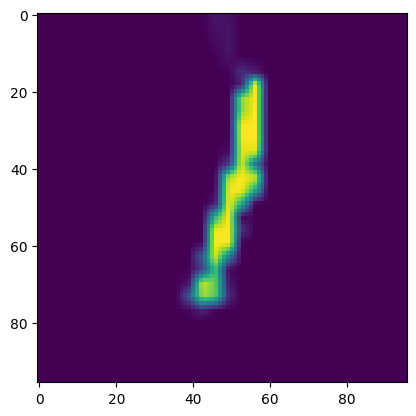

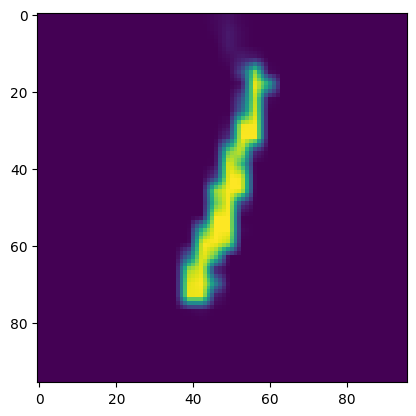

-------------------- ✔✔✔ ✔✔✔ (1) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


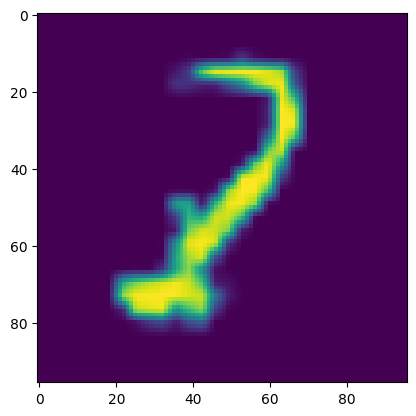

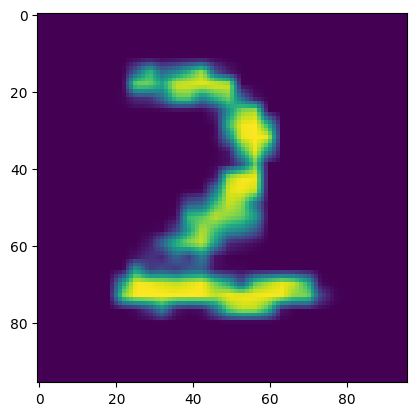

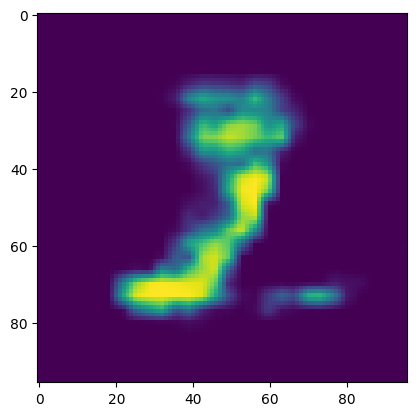

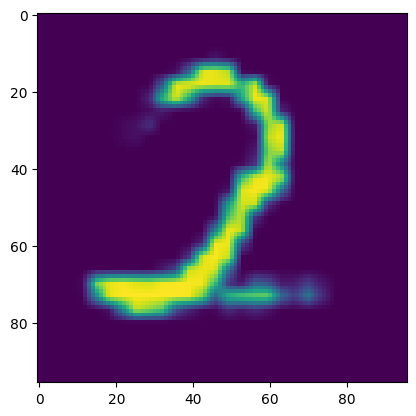

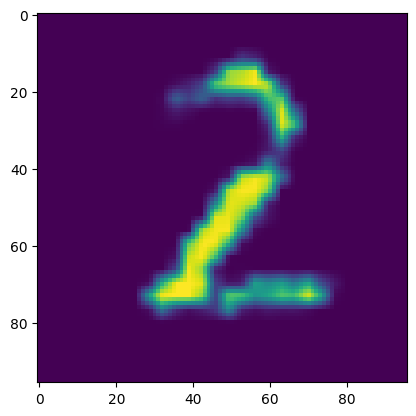

-------------------- ✔✔✔ ✔✔✔ (2) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


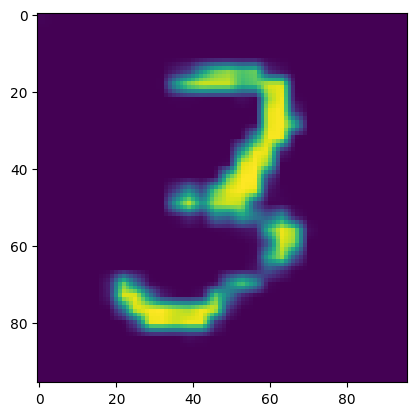

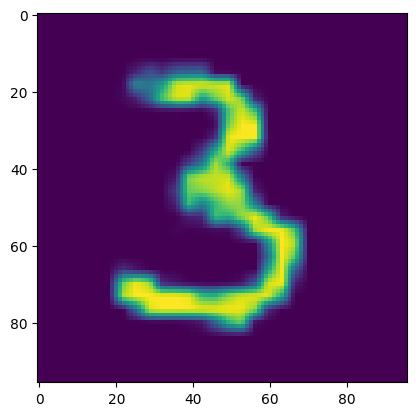

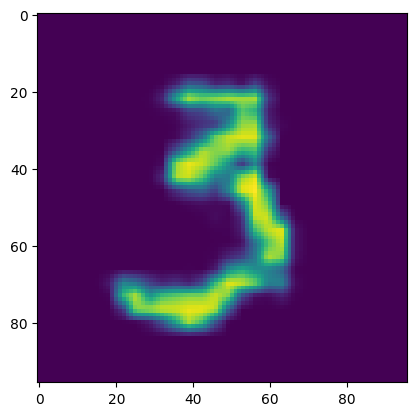

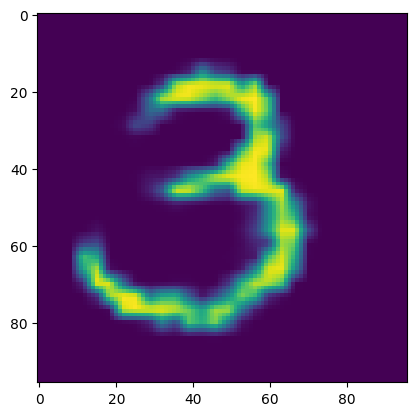

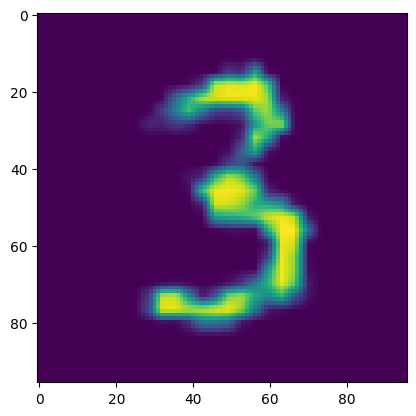

-------------------- ✔✔✔ ✔✔✔ (3) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


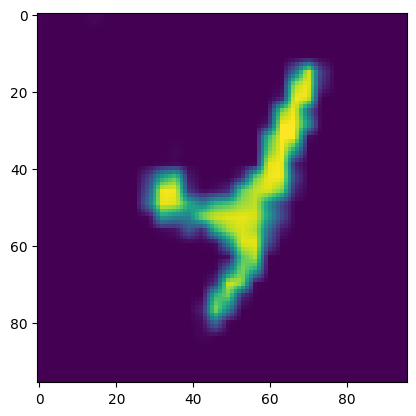

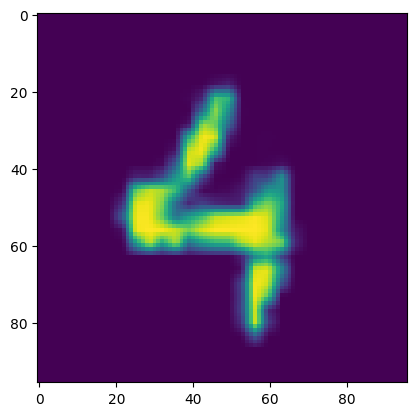

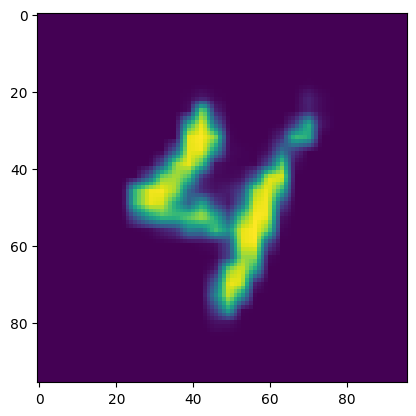

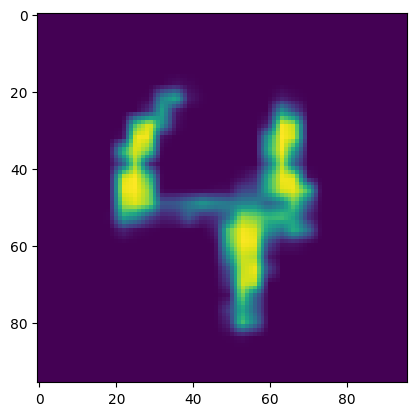

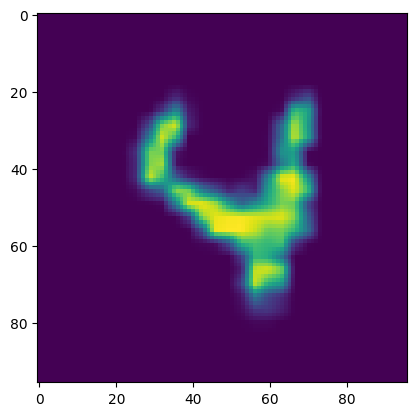

-------------------- ✔✔✔ ✔✔✔ (4) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


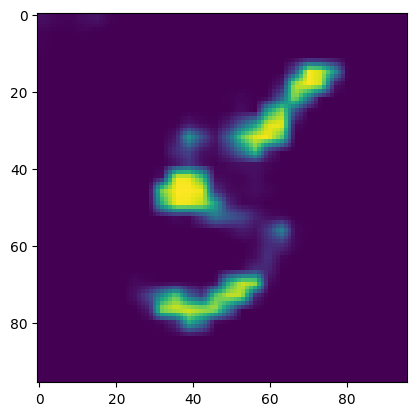

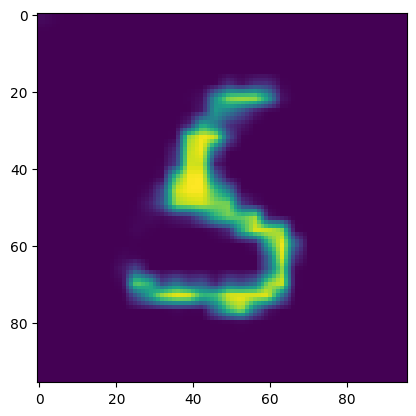

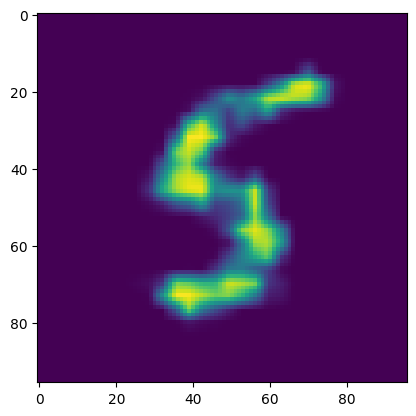

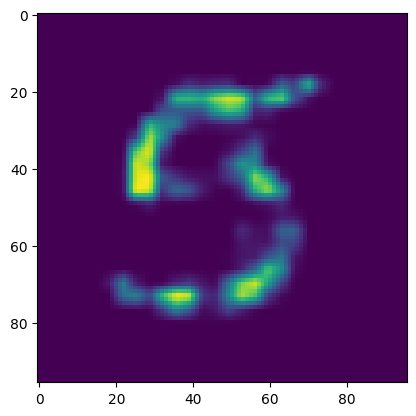

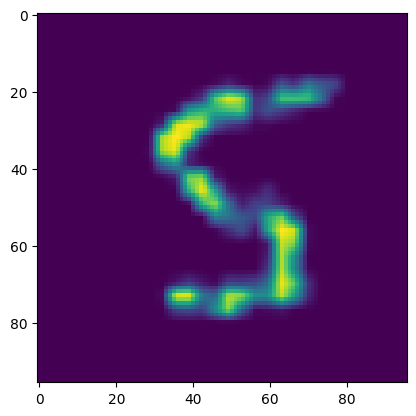

-------------------- ✔✔✔ ✔✔✔ (5) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


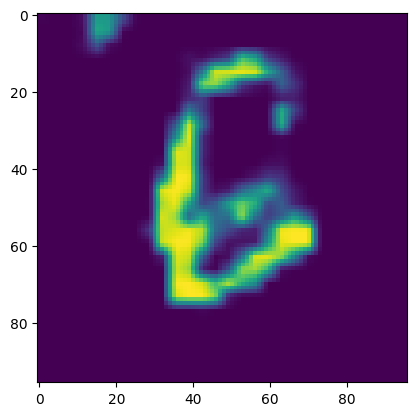

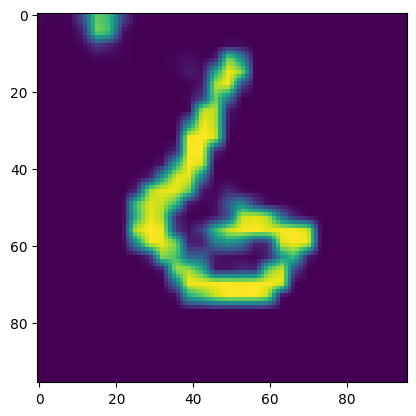

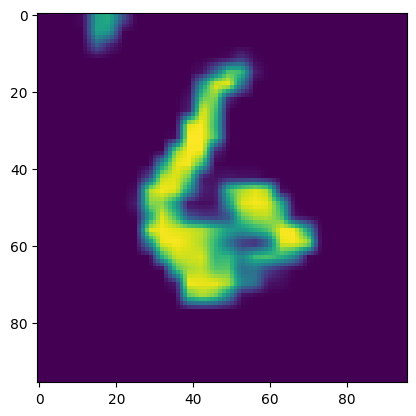

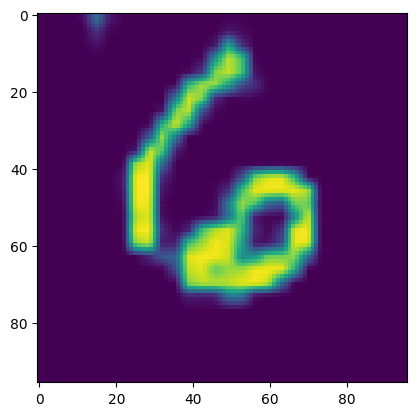

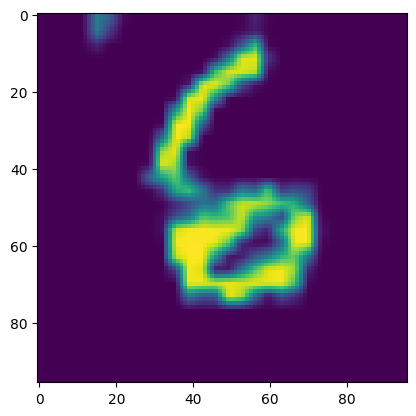

-------------------- ✔✔✔ ✔✔✔ (6) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


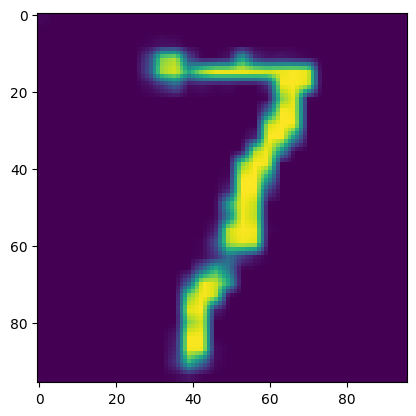

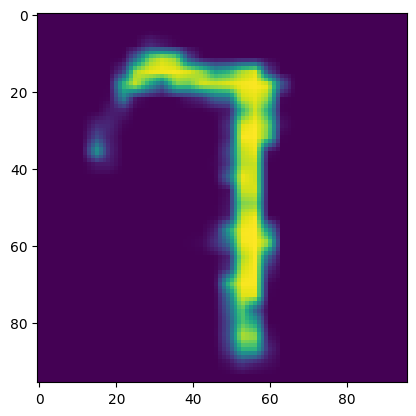

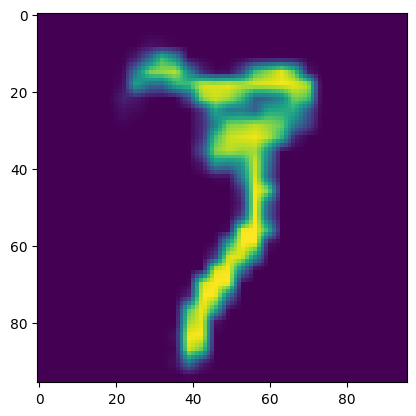

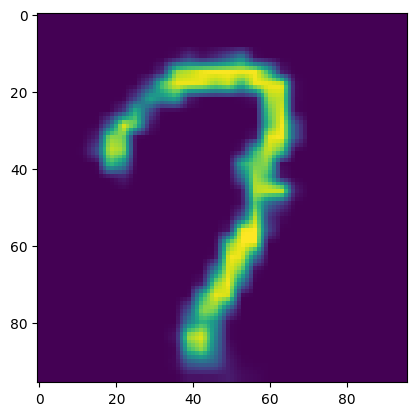

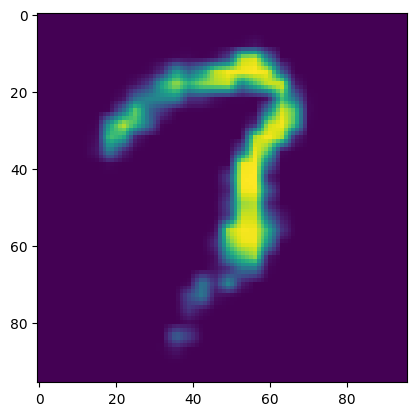

-------------------- ✔✔✔ ✔✔✔ (7) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


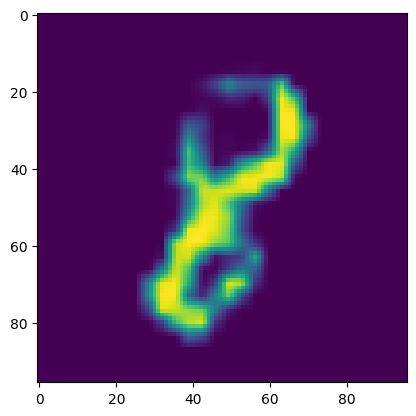

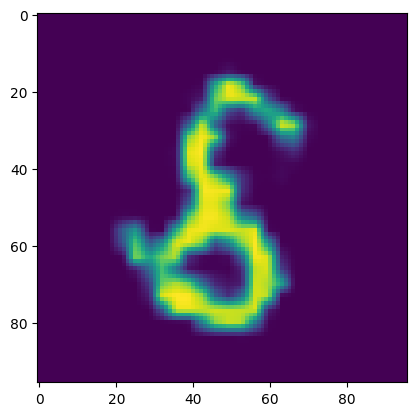

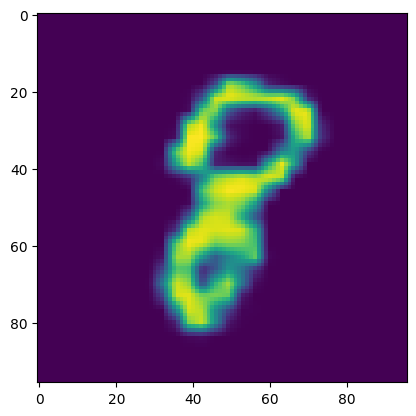

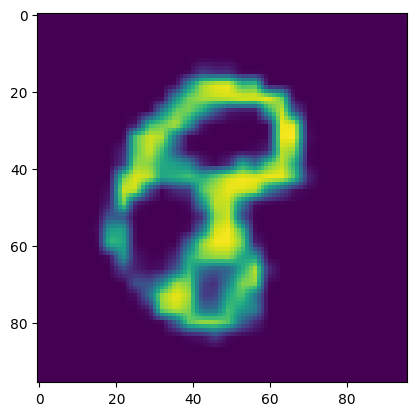

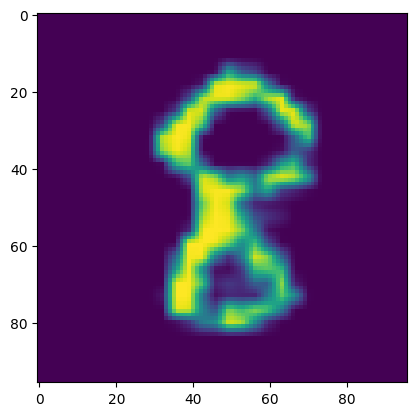

-------------------- ✔✔✔ ✔✔✔ (8) ✔✔✔ ✔✔✔ --------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


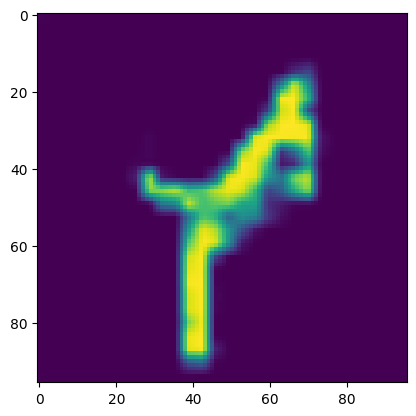

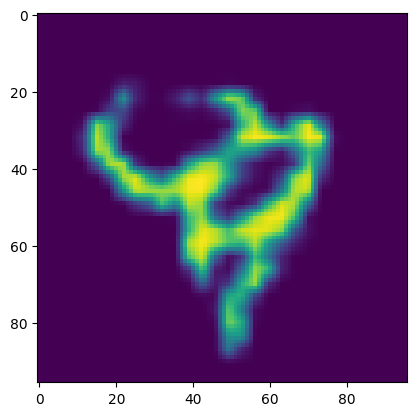

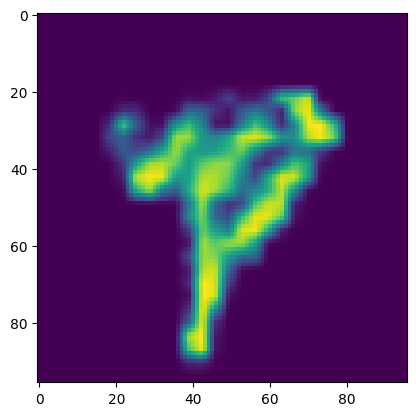

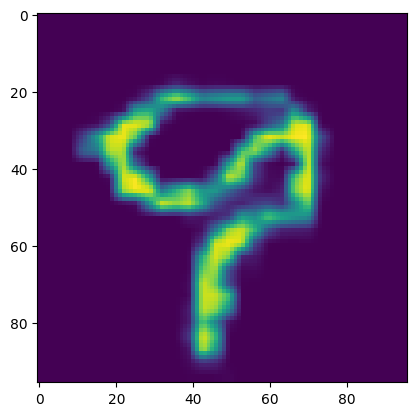

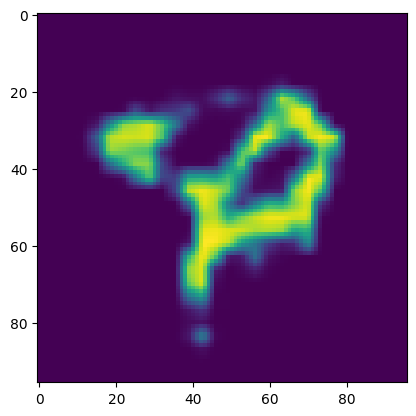

-------------------- ✔✔✔ ✔✔✔ (9) ✔✔✔ ✔✔✔ --------------------


In [ ]:
##### import matplotlib.pyplot as plt
# We first extract the trained generator from our Conditional GAN.
trained_gen = global_cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
# num_interpolation = 5  # @param {type:"integer"}
num_interpolation = 5

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake

for i in range(10):
  # start_class = 5  # @param {type:"slider", min:0, max:9, step:1}
  # end_class = 5  # @param {type:"slider", min:0, max:9, step:1}

  start_class = i
  end_class = i
  fake_images = interpolate_class(start_class, end_class)

  fake_images *= 255.0
  converted_images = fake_images.astype(np.uint8)
  converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)

  for img in converted_images:
    plt.imshow(img)
    plt.show()

  print(f"{'-'*20} ✔✔✔ ✔✔✔ ({i}) ✔✔✔ ✔✔✔ {'-'*20}")

**Evaluation Matrix:**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9130 - loss: 0.2849 - val_accuracy: 0.9839 - val_loss: 0.0495
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9867 - loss: 0.0441 - val_accuracy: 0.9840 - val_loss: 0.0492
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9913 - loss: 0.0285 - val_accuracy: 0.9882 - val_loss: 0.0367
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9944 - loss: 0.0199 - val_accuracy: 0.9868 - val_loss: 0.0433
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9903 - val_loss: 0.0372


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Classifier accuracy on generated images: 10.40%


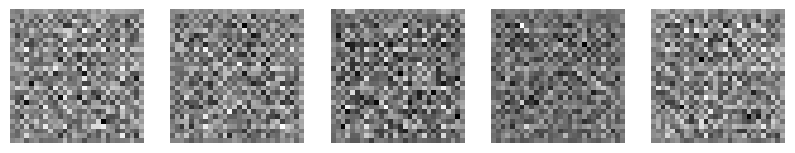

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images
x_train = np.expand_dims(x_train, axis=-1)  # Expand dimensions for CNN input
x_test = np.expand_dims(x_test, axis=-1)

# Define a simple classifier
classifier = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

# -------------------- Define the Generator (GAN) --------------------

latent_dim = 100  # Latent space dimension

# Generator model
generator = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
    layers.Dense(7 * 7 * 128, activation='relu'),
    layers.Reshape((7, 7, 128)),
    layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')  # Output shape (28, 28, 1)
])

generator.compile(optimizer='adam', loss='binary_crossentropy')

# Train the generator (for demonstration, normally it should be trained with a GAN)
def train_generator(generator, epochs=5000, batch_size=32):
    for epoch in range(epochs):
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
        fake_images = generator(random_latent_vectors, training=True)

train_generator(generator, epochs=1000)  # Quick training (increase epochs for better results)

# ------------------ Generate Synthetic Images ------------------

num_samples = 1000  # Number of generated images

random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))  # Generate random latent space vectors

fake_images = generator.predict(random_latent_vectors)  # Generate images
fake_images = np.squeeze(fake_images, axis=-1)  # Remove last dimension to match classifier input

# ------------------ Evaluate Classifier on Synthetic Data ------------------

predicted_labels = np.argmax(classifier.predict(fake_images), axis=1)
accuracy = accuracy_score(np.random.randint(0, 10, num_samples), predicted_labels)

print(f"Classifier accuracy on generated images: {accuracy * 100:.2f}%")

# Display some generated images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()


**FID:**

In [ ]:
!pip install -q tensorflow-probability

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm
import numpy as np

def calculate_fid(model, images1, images2):
    """
    Calculate Frechet Inception Distance between two sets of images.

    Args:
        model: Pre-trained InceptionV3 model.
        images1: Numpy array of real images.
        images2: Numpy array of generated images.

    Returns:
        fid: Frechet Inception Distance.
    """
    # Ensure images are in [0, 255] range
    images1 = images1 * 255.0
    images2 = images2 * 255.0

    # Resize images to (299, 299) for InceptionV3
    images1 = tf.image.resize(images1, (299, 299))
    images2 = tf.image.resize(images2, (299, 299))

    # Preprocess images for InceptionV3
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    # Get activations from the InceptionV3 model
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
# Load InceptionV3 model and remove classification layers
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
fid_model = Model(inputs=inception_model.input, outputs=inception_model.layers[-1].output)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Generate synthetic images using the trained generator
num_samples = 1000
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))
fake_images = generator(random_latent_vectors, training=False)

# Reshape fake images to match InceptionV3 input shape
fake_images = tf.repeat(fake_images, repeats=3, axis=-1)  # Convert grayscale to RGB
fake_images = tf.image.resize(fake_images, (299, 299))

# Select a subset of real images for comparison
real_images = all_digits[:num_samples]
real_images = tf.repeat(real_images, repeats=3, axis=-1)  # Convert grayscale to RGB
real_images = tf.image.resize(real_images, (299, 299))

In [ ]:
# Calculate FID between real and generated images
fid_score = calculate_fid(fid_model, real_images, fake_images)
print(f"Frechet Inception Distance (FID): {fid_score:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 448ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
Frechet Inception Distance (FID): 425.74


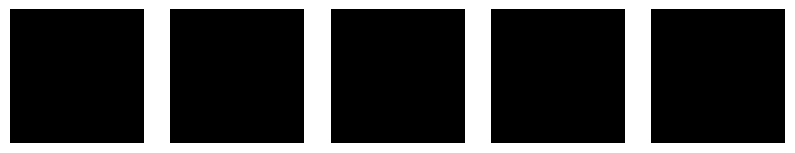

In [ ]:
# Display some generated images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(fake_images[i] / 255.0)  # Normalize back to [0, 1]
    axes[i].axis('off')
plt.show()

**IS**: To Compute the Inception Score for the generated images.

In [ ]:
# Install required libraries if not already installed
!pip install -q tensorflow-probability scipy

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from scipy.stats import entropy
import numpy as np

# Define the Inception Score function
def calculate_inception_score(model, images, batch_size=32, splits=10):
    """
    Calculate the Inception Score for a set of generated images.

    Args:
        model: Pre-trained InceptionV3 model.
        images: Numpy array of generated images.
        batch_size: Batch size for processing images.
        splits: Number of splits for calculating the score.

    Returns:
        mean_IS: Mean Inception Score.
        std_IS: Standard deviation of the Inception Score.
    """
    # Ensure images are in [0, 255] range
    images = images * 255.0

    # Resize images to (299, 299) for InceptionV3
    images = tf.image.resize(images, (299, 299))

    # Preprocess images for InceptionV3
    images = preprocess_input(images)

    # Get predictions from the InceptionV3 model
    preds = model.predict(images, batch_size=batch_size)

    # Compute KL divergence and Inception Score
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        p_y = np.mean(part, axis=0)
        scores.append(np.exp(entropy(part, p_y)))

    mean_IS = np.mean(scores)
    std_IS = np.std(scores)
    return mean_IS, std_IS

# Load pre-trained InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
is_model = Model(inputs=inception_model.input, outputs=inception_model.layers[-1].output)

# Generate synthetic images using the trained generator
num_samples = 1000  # Number of generated images
latent_dim = 128  # Latent space dimension
num_classes = 10  # Number of classes in MNIST

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

# Generate random one-hot encoded class labels
random_labels = tf.random.uniform(shape=(num_samples,), minval=0, maxval=num_classes, dtype=tf.int32)
random_one_hot_labels = tf.one_hot(random_labels, depth=num_classes)

# Concatenate latent vectors and one-hot encoded labels
random_vector_labels = tf.concat([random_latent_vectors, random_one_hot_labels], axis=1)

# Generate fake images using the generator
fake_images = global_cond_gan.generator(random_vector_labels, training=False)

# Convert grayscale images to RGB for InceptionV3 compatibility
fake_images = tf.repeat(fake_images, repeats=3, axis=-1)

# Calculate Inception Score
mean_IS, std_IS = calculate_inception_score(is_model, fake_images.numpy())
print(f"Inception Score: Mean = {mean_IS:.2f}, Std = {std_IS:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step
Inception Score: Mean = nan, Std = nan


/usr/local/lib/python3.11/dist-packages/scipy/stats/_entropy.py:151: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / np.sum(qk, **sum_kwargs)  # type: ignore[operator, call-overload]


**Precision and Recall: Evaluate the malicious client detection mechanism using these metrics:**

In [ ]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score

# Initialize variables for tracking true positives, false positives, and false negatives
true_positives = 0
false_positives = 0
false_negatives = 0

# Assume `attacker_nodes` contains the indices of actual malicious clients
actual_malicious_clients = set(attacker_nodes)

# Loop through detected malicious clients and update TP, FP, FN
for comm_round in range(global_epochs):
    if comm_round > 0:  # Ensure detection starts after at least one round
        malicious_clients = detect_malicious_clients(local_gen_losses, local_disc_losses)
        detected_malicious_clients = set(malicious_clients)

        # Update true positives (correctly detected malicious clients)
        true_positives += len(actual_malicious_clients.intersection(detected_malicious_clients))

        # Update false positives (non-malicious clients incorrectly flagged as malicious)
        false_positives += len(detected_malicious_clients - actual_malicious_clients)

        # Update false negatives (malicious clients not detected)
        false_negatives += len(actual_malicious_clients - detected_malicious_clients)

# Calculate Precision and Recall
if (true_positives + false_positives) > 0:
    precision = true_positives / (true_positives + false_positives)
else:
    precision = 0

if (true_positives + false_negatives) > 0:
    recall = true_positives / (true_positives + false_negatives)
else:
    recall = 0

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

[0 2 3]
[0 2 3]
[0 2 3]
[0 2 3]
[0 2 3]
[0 2 3]
[0 2 3]
[0 2 3]
[0 2 3]
Precision: 1.00
Recall: 0.50


**Visualisation:**

**Generated Image Grids:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


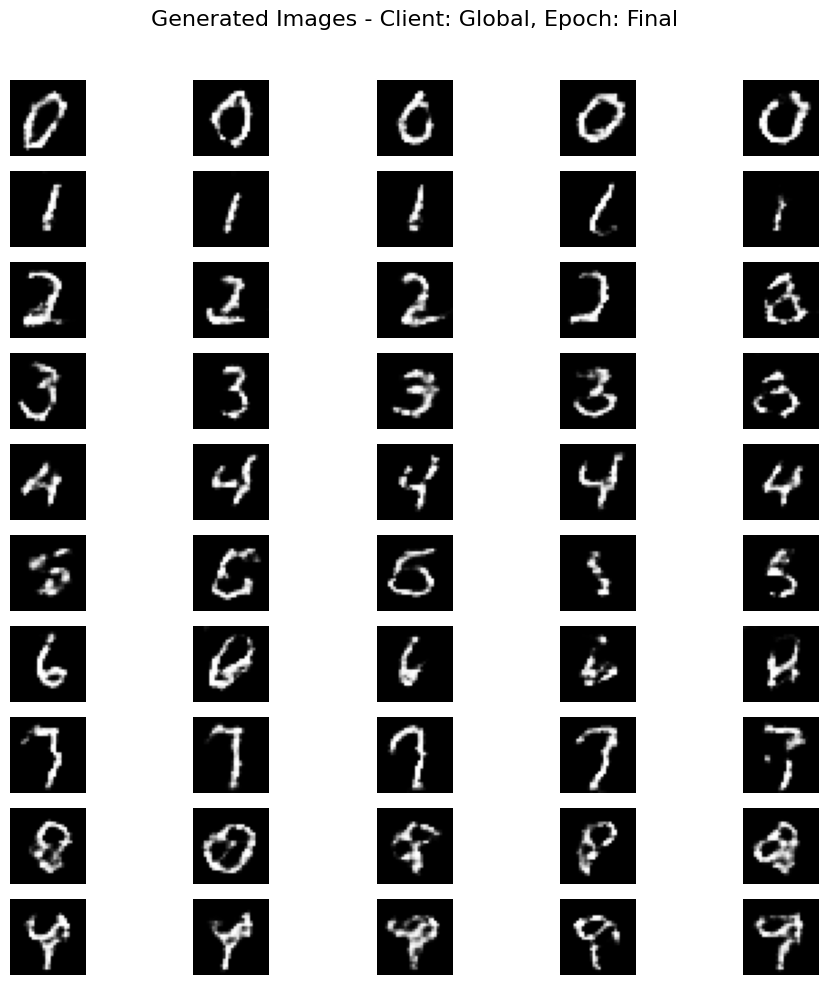

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_generated_image_grid(generator, latent_dim, num_classes, num_samples_per_class=5, client_name=None, epoch=None):
    """
    Visualize a grid of generated images for each class.

    Args:
        generator: Trained generator model.
        latent_dim: Dimension of the latent space.
        num_classes: Number of classes in the dataset.
        num_samples_per_class: Number of samples to generate per class.
        client_name: Optional name of the client (for labeling).
        epoch: Optional epoch number (for labeling).
    """
    # Create a figure for visualization
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(10, 10))
    fig.suptitle(f"Generated Images - Client: {client_name}, Epoch: {epoch}", fontsize=16)

    # Generate images for each class
    for class_label in range(num_classes):
        # Create one-hot encoded label for the current class
        one_hot_label = keras.utils.to_categorical([class_label], num_classes)
        one_hot_labels = np.repeat(one_hot_label, num_samples_per_class, axis=0)

        # Sample random latent vectors
        random_latent_vectors = tf.random.normal(shape=(num_samples_per_class, latent_dim))

        # Concatenate latent vectors and labels
        input_vectors = np.concatenate([random_latent_vectors, one_hot_labels], axis=1)

        # Generate images
        generated_images = generator.predict(input_vectors)

        # Display the generated images
        for i in range(num_samples_per_class):
            ax = axes[class_label, i]
            img = generated_images[i].squeeze()  # Remove channel dimension
            ax.imshow(img, cmap='gray')
            ax.axis('off')

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
    plt.show()

# Example usage: Visualize generated images at the end of training
latent_dim = 128  # Latent space dimension
num_classes = 10  # Number of classes in MNIST

# Visualize images from the global generator
visualize_generated_image_grid(global_cond_gan.generator, latent_dim, num_classes, num_samples_per_class=5, client_name="Global", epoch="Final")

# Optional: Visualize images from specific clients during training
# for client_name, data in clients_batched.items():
#     client_generator = ...  # Extract the generator from the client's local model
#     visualize_generated_image_grid(client_generator, latent_dim, num_classes, num_samples_per_class=5, client_name=client_name, epoch=comm_round)


**Loss Curves:**

Epoch 1/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - d_loss: 0.6538 - g_loss: 0.8105
Epoch 2/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6602 - g_loss: 0.8027
Epoch 3/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.6558 - g_loss: 0.8052
Epoch 4/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6580 - g_loss: 0.7801
Epoch 1/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - d_loss: 0.6459 - g_loss: 0.8042
Epoch 2/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - d_loss: 0.6602 - g_loss: 0.7942
Epoch 3/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6561 - g_loss: 0.7979
Epoch 4/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6654 - g_loss: 0.7756
Epoch 1/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6646 - g_loss: 0.7725
Epoch 2/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - d_loss: 0.6614 - g_loss: 0.7820
Epoch 3/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6657 - g_loss: 0.7696
Epoch 4/4
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step -

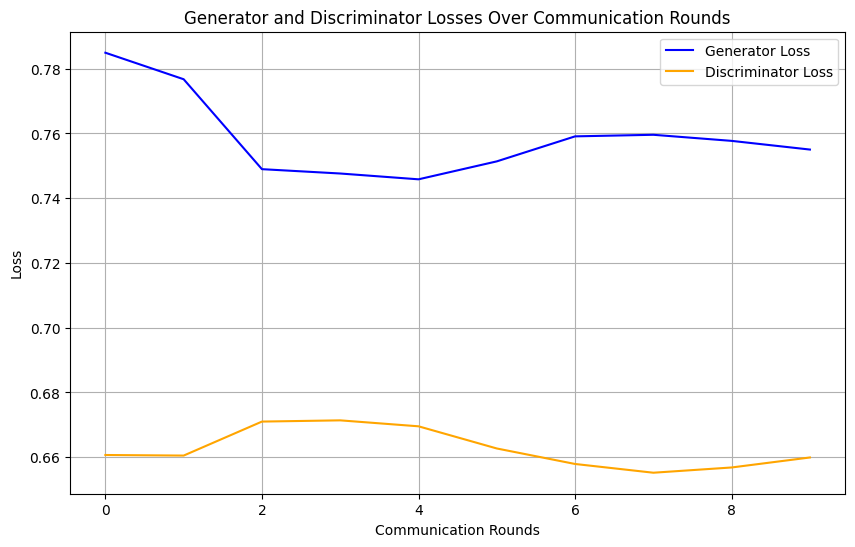

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store global generator and discriminator losses
global_gen_losses = []
global_disc_losses = []

# Modify the training loop to collect losses
for comm_round in range(global_epochs):
    # ... (existing code for training)

    # Collect local generator and discriminator losses
    local_gen_losses = []
    local_disc_losses = []

    for i, client in enumerate(clients_batched.keys()):
        # Train the local model (existing code)
        history = smlp_local.fit(data_set, epochs=4, verbose=1)

        # Store losses
        for key in history.history:
            if 'g_loss' in key:
                local_gen_losses.append(history.history[key][-1])  # Take the last loss value
            elif 'd_loss' in key:
                local_disc_losses.append(history.history[key][-1])  # Take the last loss value

    # Compute average losses across all clients for this communication round
    avg_gen_loss = np.mean(local_gen_losses)
    avg_disc_loss = np.mean(local_disc_losses)

    # Append to global loss lists
    global_gen_losses.append(avg_gen_loss)
    global_disc_losses.append(avg_disc_loss)

    print(f"Communication Round {comm_round + 1}: Avg Gen Loss = {avg_gen_loss:.4f}, Avg Disc Loss = {avg_disc_loss:.4f}")

# Plot the loss curves after training
def plot_loss_curves(gen_losses, disc_losses):
    """
    Plot generator and discriminator loss curves over epochs.

    Args:
        gen_losses: List of generator losses over epochs.
        disc_losses: List of discriminator losses over epochs.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(gen_losses, label="Generator Loss", color="blue")
    plt.plot(disc_losses, label="Discriminator Loss", color="orange")
    plt.title("Generator and Discriminator Losses Over Communication Rounds")
    plt.xlabel("Communication Rounds")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss curves
plot_loss_curves(global_gen_losses, global_disc_losses)

**t-SNE or PCA Plots: **

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step


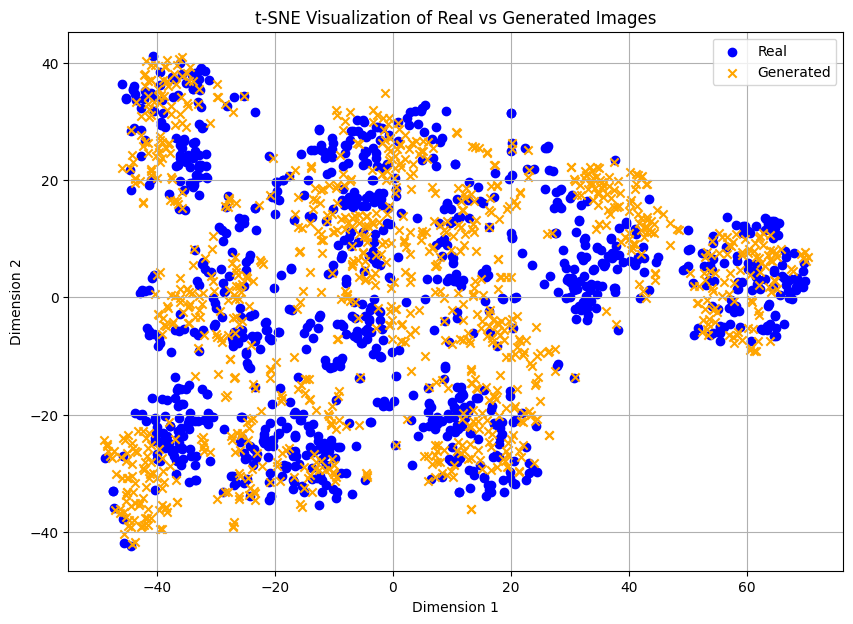

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

# Load pre-trained InceptionV3 model for feature extraction
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
feature_extractor = Model(inputs=inception_model.input, outputs=inception_model.layers[-1].output)

def extract_features(model, images):
    """
    Extract features from images using the provided model.

    Args:
        model: Pre-trained feature extraction model.
        images: Numpy array of images.

    Returns:
        features: Extracted features.
    """
    # Ensure images are in [0, 255] range
    images = images * 255.0

    # Resize images to (299, 299) for InceptionV3
    images = tf.image.resize(images, (299, 299))

    # Preprocess images for InceptionV3
    images = preprocess_input(images)

    # Extract features
    features = model.predict(images)
    return features

# Generate synthetic images using the trained generator
num_samples = 1000  # Number of generated images
latent_dim = 128  # Latent space dimension
num_classes = 10  # Number of classes in MNIST

# Generate random latent vectors
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

# Generate random one-hot encoded class labels
random_labels = tf.random.uniform(shape=(num_samples,), minval=0, maxval=num_classes, dtype=tf.int32)
random_one_hot_labels = tf.one_hot(random_labels, depth=num_classes)

# Concatenate latent vectors and one-hot encoded labels
random_vector_labels = tf.concat([random_latent_vectors, random_one_hot_labels], axis=1)

# Generate fake images using the global generator
fake_images = global_cond_gan.generator(random_vector_labels, training=False)

# Convert grayscale images to RGB for InceptionV3 compatibility
fake_images_rgb = tf.repeat(fake_images, repeats=3, axis=-1)

# Select a subset of real images for comparison
real_images = all_digits[:num_samples]
real_images_rgb = tf.repeat(real_images, repeats=3, axis=-1)  # Convert grayscale to RGB

# Extract features for real and generated images
real_features = extract_features(feature_extractor, real_images_rgb)
fake_features = extract_features(feature_extractor, fake_images_rgb)

# Combine features and create labels for visualization
all_features = np.vstack([real_features, fake_features])
labels = np.array([0] * num_samples + [1] * num_samples)  # 0 for real, 1 for fake

# Apply t-SNE or PCA for dimensionality reduction
def reduce_dimensions(features, method='tsne', n_components=2):
    if method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=n_components, random_state=42)
    else:
        raise ValueError("Unsupported method. Use 'tsne' or 'pca'.")
    reduced_features = reducer.fit_transform(features)
    return reduced_features

reduced_features = reduce_dimensions(all_features, method='tsne')  # Change to 'pca' if needed

# Plot the results
plt.figure(figsize=(10, 7))
for label, color, marker in zip([0, 1], ['blue', 'orange'], ['o', 'x']):
    indices = labels == label
    plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], c=color, marker=marker, label=f"{'Real' if label == 0 else 'Generated'}")

plt.title("t-SNE Visualization of Real vs Generated Images")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()

**Confusion Matrix: **

[1 2]


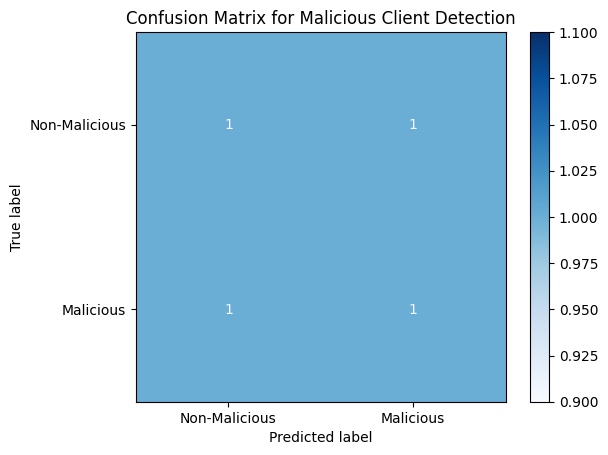

True Positives (TP): 1
False Positives (FP): 1
True Negatives (TN): 1
False Negatives (FN): 1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to compute and display the confusion matrix
def plot_confusion_matrix(actual_malicious_clients, detected_malicious_clients, num_clients):
    """
    Plot the confusion matrix for malicious client detection.

    Args:
        actual_malicious_clients: List of indices of actual malicious clients.
        detected_malicious_clients: List of indices of detected malicious clients.
        num_clients: Total number of clients.
    """
    # Create binary labels for all clients
    actual_labels = [1 if i in actual_malicious_clients else 0 for i in range(num_clients)]
    detected_labels = [1 if i in detected_malicious_clients else 0 for i in range(num_clients)]

    # Compute the confusion matrix
    cm = confusion_matrix(actual_labels, detected_labels)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Malicious", "Malicious"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Malicious Client Detection")
    plt.show()

    # Print detailed metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")

# Example usage: Evaluate malicious client detection at the end of training
num_clients = len(clients_batched.keys())  # Total number of clients
actual_malicious_clients = attacker_nodes  # Actual malicious clients
detected_malicious_clients = detect_malicious_clients(local_gen_losses, local_disc_losses)  # Detected malicious clients

# Plot the confusion matrix
plot_confusion_matrix(actual_malicious_clients, detected_malicious_clients, num_clients)

**Loss Histograms:**


<================  Communication Round : 1 ================>


<== End of Communication Round 1 ==
Number of local generators trained: 0
Number of local discriminators trained: 0
Local generator losses: []
Local discriminator losses: []

<================  Communication Round : 2 ================>


<== End of Communication Round 2 ==
Number of local generators trained: 0
Number of local discriminators trained: 0
Local generator losses: []
Local discriminator losses: []
[]

Highly malicious clients (Detected): []

<================  Communication Round : 3 ================>


<== End of Communication Round 3 ==
Number of local generators trained: 0
Number of local discriminators trained: 0
Local generator losses: []
Local discriminator losses: []
[]

Highly malicious clients (Detected): []

<================  Communication Round : 4 ================>


<== End of Communication Round 4 ==
Number of local generators trained: 0
Number of local discriminators trained: 0
Local generator lo

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-52-19f184386e9d>:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


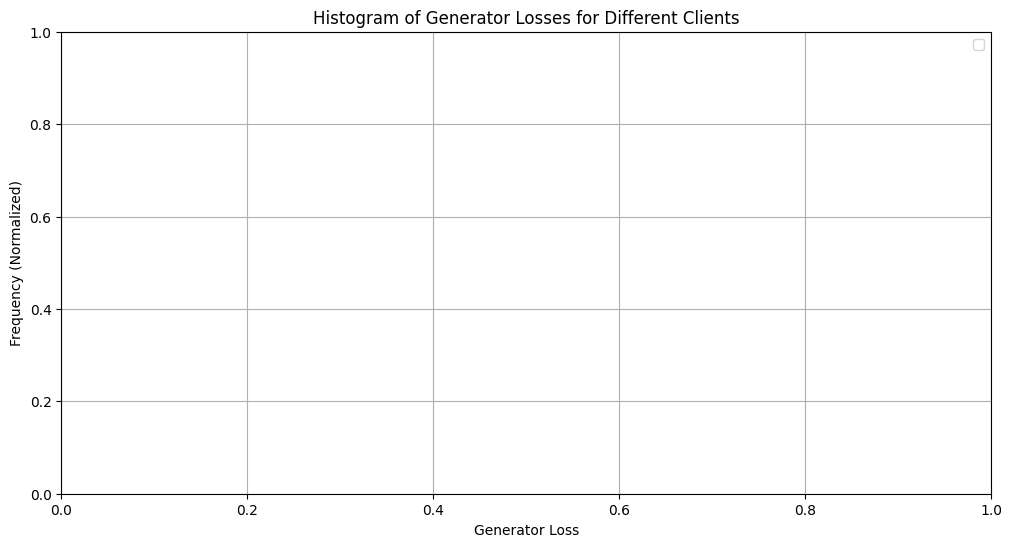

<ipython-input-52-19f184386e9d>:140: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


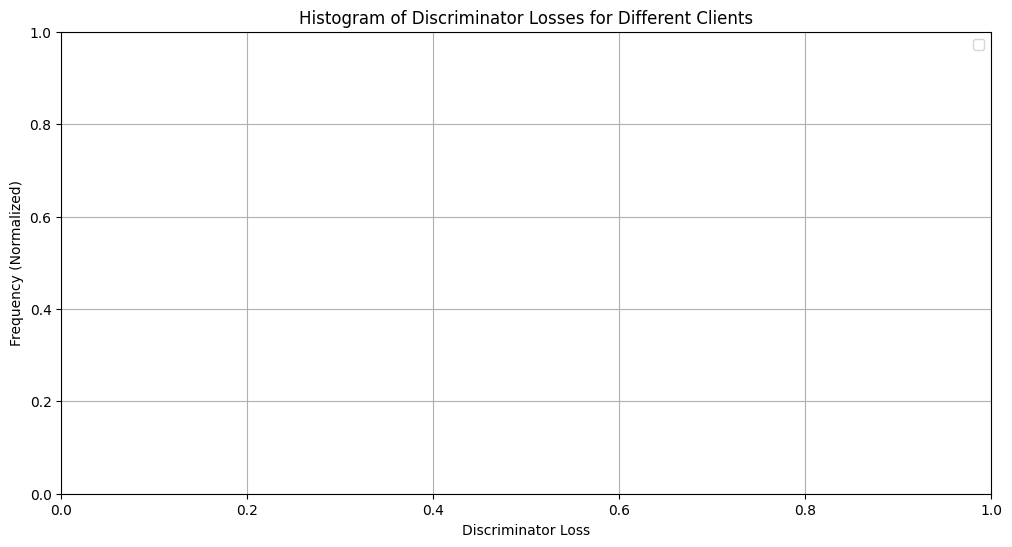

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the generator model that accepts latent vector + one-hot encoded labels
def build_generator(latent_dim, num_classes):
    model = keras.Sequential()

    # Input layer: latent vector + one-hot encoded labels
    model.add(layers.InputLayer(input_shape=(latent_dim + num_classes,)))

    # Define the rest of your generator model
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28 * 28 * 3, activation='sigmoid'))  # RGB images (28x28x3)
    model.add(layers.Reshape((28, 28, 3)))  # Assuming MNIST with RGB output

    return model

# Initialize model components
latent_dim = 128
num_classes = 10
clients_batched = {}  # Assuming this is defined with client data

# Initialize dictionaries to store generator and discriminator losses for each client
client_gen_losses = {client_name: [] for client_name in clients_batched.keys()}
client_disc_losses = {client_name: [] for client_name in clients_batched.keys()}

# Global generator and discriminator models (to be used in federated learning)
global_cond_gan = type('', (), {})()  # Placeholder for global model object
global_cond_gan.generator = build_generator(latent_dim, num_classes)
global_cond_gan.discriminator = build_generator(latent_dim, num_classes)  # Assuming same structure for discriminator

# Compile models to make sure weights are initialized
global_cond_gan.generator.compile(optimizer='adam', loss='binary_crossentropy')
global_cond_gan.discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Initial weights of the global models
initial_generator_weights = global_cond_gan.generator.get_weights()
initial_discriminator_weights = global_cond_gan.discriminator.get_weights()

# Helper function to aggregate weights
def sum_scaled_weights_locals(weights_list):
    # Compute the average weights
    average_weights = []
    for layer_weights in zip(*weights_list):
        average_weights.append(np.mean(np.array(layer_weights), axis=0))
    return average_weights

# Modify the training loop to collect losses for each client
for comm_round in range(global_epochs):
    print(f"\n<================  Communication Round : {comm_round + 1} ================>\n")

    scaled_local_gen = []
    scaled_local_disc = []
    local_gen_losses = []
    local_disc_losses = []

    for i, client in enumerate(clients_batched.keys()):
        smlp_local = ConditionalGANLocal(
            discriminator=global_cond_gan.discriminator,
            generator=global_cond_gan.generator,
            latent_dim=latent_dim,
            global_gen_weights=global_cond_gan.generator.get_weights(),
            global_disc_weights=global_cond_gan.discriminator.get_weights()
        )
        smlp_local.compile(
            d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            loss_fn=keras.losses.BinaryCrossentropy(from_logits=True)
        )
        data_set = clients_batched[client]

        # Train the local model
        history = smlp_local.fit(data_set, epochs=4, verbose=0)

        # Store generator and discriminator losses for this client
        if 'g_loss' in history.history:
            client_gen_losses[client].extend(history.history['g_loss'])
            local_gen_losses.append(np.mean(history.history['g_loss']))  # Append mean loss for detection
        if 'd_loss' in history.history:
            client_disc_losses[client].extend(history.history['d_loss'])
            local_disc_losses.append(np.mean(history.history['d_loss']))  # Append mean loss for detection

        # Save the trained local models
        scaled_local_gen.append(smlp_local.generator)
        scaled_local_disc.append(smlp_local.discriminator)

    # Debugging: Check if the lists are populated with weights
    print(f"\n<== End of Communication Round {comm_round + 1} ==")
    print(f"Number of local generators trained: {len(scaled_local_gen)}")
    print(f"Number of local discriminators trained: {len(scaled_local_disc)}")

    # Aggregate losses
    print("Local generator losses:", local_gen_losses)
    print("Local discriminator losses:", local_disc_losses)

    # Detect malicious clients (optional)
    if comm_round > 0:
        malicious_clients = detect_malicious_clients(local_gen_losses, local_disc_losses)
        print("\nHighly malicious clients (Detected):", malicious_clients)

    # Aggregate weights of local models
    if len(scaled_local_gen) > 0:
        scaled_local_gen_weight_list = [model.get_weights() for model in scaled_local_gen]
        print(f"Local generator weights shape: {len(scaled_local_gen_weight_list)}")
    if len(scaled_local_disc) > 0:
        scaled_local_disc_weight_list = [model.get_weights() for model in scaled_local_disc]
        print(f"Local discriminator weights shape: {len(scaled_local_disc_weight_list)}")

    # Ensure correct weight aggregation function is used
    if len(scaled_local_gen_weight_list) > 0:
        average_weights_gen = sum_scaled_weights_locals(scaled_local_gen_weight_list)
        global_cond_gan.generator.set_weights(average_weights_gen)
    if len(scaled_local_disc_weight_list) > 0:
        average_weights_disc = sum_scaled_weights_locals(scaled_local_disc_weight_list)
        global_cond_gan.discriminator.set_weights(average_weights_disc)

# Plot histograms for generator losses
plt.figure(figsize=(12, 6))
for client, gen_losses in client_gen_losses.items():
    plt.hist(gen_losses, bins=20, alpha=0.5, label=f"Client {client}", density=True)
plt.title("Histogram of Generator Losses for Different Clients")
plt.xlabel("Generator Loss")
plt.ylabel("Frequency (Normalized)")
plt.legend()
plt.grid(True)
plt.show()

# Plot histograms for discriminator losses
plt.figure(figsize=(12, 6))
for client, disc_losses in client_disc_losses.items():
    plt.hist(disc_losses, bins=20, alpha=0.5, label=f"Client {client}", density=True)
plt.title("Histogram of Discriminator Losses for Different Clients")
plt.xlabel("Discriminator Loss")
plt.ylabel("Frequency (Normalized)")
plt.legend()
plt.grid(True)
plt.show()


Histogram of losses

In [ ]:
# Re-initialize and run the analysis after the reset

import matplotlib.pyplot as plt
import numpy as np

# Loss values from the data provided for d_loss and g_loss
d_loss_values = [
    0.6538, 0.6602, 0.6558, 0.6580, 0.6459, 0.6602, 0.6561, 0.6654,
    0.6646, 0.6614, 0.6657, 0.6648, 0.6694, 0.6710, 0.6602, 0.6583,
    0.6690, 0.6686, 0.6668, 0.6578, 0.6654, 0.6645, 0.6644, 0.6632,
    0.6632, 0.6649, 0.6619, 0.6633, 0.6627, 0.6596, 0.6601, 0.6593,
    0.6596, 0.6618, 0.6616, 0.6617, 0.6628, 0.6615, 0.6613, 0.6630,
    0.6611, 0.6608, 0.6643, 0.6637, 0.6645, 0.6615, 0.6605, 0.6628
]

g_loss_values = [
    0.8105, 0.8027, 0.8052, 0.7801, 0.8042, 0.7942, 0.7979, 0.7756,
    0.7725, 0.7820, 0.7696, 0.7663, 0.7676, 0.7651, 0.7718, 0.7663,
    0.7600, 0.7595, 0.7563, 0.7762, 0.7608, 0.7599, 0.7604, 0.7584,
    0.7591, 0.7596, 0.7610, 0.7587, 0.7598, 0.7577, 0.7625, 0.7547,
    0.7587, 0.7593, 0.7585, 0.7610, 0.7591, 0.7598, 0.7609, 0.7575,
    0.7614, 0.7603, 0.7567, 0.7595, 0.7599, 0.7594, 0.7598, 0.7574
]

# Create histograms for the discriminator loss and generator loss
plt.figure(figsize=(12, 6))

# Plotting discriminator loss
plt.subplot(1, 2, 1)
plt.hist(d_loss_values, bins=10, color='orange', alpha=0.7)
plt.title("Discriminator Loss Histogram")
plt.xlabel("Loss")
plt.ylabel("Frequency")

# Plotting generator loss
plt.subplot(1, 2, 2)
plt.hist(g_loss_values, bins=10, color='blue', alpha=0.7)
plt.title("Generator Loss Histogram")
plt.xlabel("Loss")
plt.ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()

# Analyzing the histograms
d_loss_mean = np.mean(d_loss_values)
g_loss_mean = np.mean(g_loss_values)

d_loss_std = np.std(d_loss_values)
g_loss_std = np.std(g_loss_values)

d_loss_median = np.median(d_loss_values)
g_loss_median = np.median(g_loss_values)

d_loss_skew = (np.mean(d_loss_values) - d_loss_median) / d_loss_std
g_loss_skew = (np.mean(g_loss_values) - g_loss_median) / g_loss_std

d_loss_kurt = np.mean(((np.array(d_loss_values) - d_loss_mean) ** 4) / (d_loss_std ** 4))
g_loss_kurt = np.mean(((np.array(g_loss_values) - g_loss_mean) ** 4) / (g_loss_std ** 4))

(d_loss_mean, d_loss_std, d_loss_median, d_loss_skew, d_loss_kurt), (g_loss_mean, g_loss_std, g_loss_median, g_loss_skew, g_loss_kurt)
